<font size="5">**Machine Learning per la previsione delle serie temporali (*time series*)**</font><br>

> (c) 2025 Antonio Piemontese

# Importazione dei package necessari

In [1]:
from pathlib import Path
import datetime

import pandas as pd
import matplotlib.pylab as plt           # per grafici
import statsmodels.formula.api as sm     # per costruire i modelli
from statsmodels.tsa import tsatools     # il modello per Time Series Analysis (TSA)

import math
import numpy as np 

%matplotlib inline                       

In [2]:
# il package 'dmba' contiene diverse utilità; è presente nel PPI (Python Package Index) e può quindi essere installato
# con il comando: 'pip install dmba' (da anaconda prompt) 
import dmba                          # la load in memoria dopo l'install (l'equivalente della 'library' di R)
from dmba import regressionSummary   # un'utile sintesi degli output del metodo di regressione


Il codice del package 'dmba' è visibile e mantenuto dall'autore a [questo link github](https://github.com/gedeck/dmba)

# Cos'è la gestione delle serie storiche (temporali)
Le tecniche di ML si occupano normalmente di **dati sezionali** (*cross-sectional*) [dati dello stesso periodo di tempo o senza considerare le differenze temporali].

Nella gestione delle serie storiche, invece, **il tempo** è un fattore trattato in modo <u>differente</u> dalle altre variabili.
Si parla di analisi **longitudinale**.

---
Di per sè, una colonna "tempo" (es. data/ora) può esserci in tutti i dataset, e non per questo si parla di analisi delle serie storiche. In queste ultime **il "tempo" gioca un ruolo chiave e spesso la colonna "data/ora" è addirittura la chiave del dataset**, quella rispetto alla quale si fanno ordinamenti oppure slicing (cioè estrazione di sottoinsiemi).

---

**Due tipi** di "gestione" delle serie storiche: 
* **Analisi** delle serie temporali (o storiche), riferita al <u>passato</u> (detta spesso **TSA** = Time Series Analysis), anche sino a ieri
* **Forecasting**, riferito al <u>futuro</u> (detta spesso **TSF** = Time Series Forecasting), da domani in poi

TSA individua **trend, relazioni, pattern stagionali e fattori esterni (driver)** della serie storica.
Il forecasting (TSF) invece prevede i **valori FUTURI** della serie storica. [nb. Forecasting <> Prediction].

> TSA è Machine Learning **descrittivo** (od esplorativo), TSF è Machine Learning **predittivo**.

I metodi (**gli algoritmi**) di ML che si usano per TSA sono quindi diversi da quelli che si usano per il TSF.
I metodi di TSA, infatti, cercano di <u>capire e spiegare</u>; quelli di TSF sono spesso <u>"black box"</u> (ci interessa la affidabilità delle previsioni, non come questa avvenga).<br>
I metodi di TSA, inoltre, sono retrospettivi (guardano al passato), quelli di TSF sono prospettici (guardano al futuro).
--> in questo corso vedremo **esempi sia di TSA che di TSF**.

In questo corso tratteremo <u>le serie storiche "singole"</u>, le più comuni e semplici.
[esempio di serie storica **multipla**: le vendite mensili di diversi prodotti INSIEME, oppure la storia degli ordini e ricavi INSIEME].
Le serie storiche singole NON gestiscono le possibili interazioni, nel senso che o la serie è singola (non possono esserci interazioni) oppure l'analisi è fatta in modo indipendente per ogni colonna, senza considerare le possibili interazioni tra colonne; la gestione di queste interazioni, tuttavia, richiede assunzioni restrittive e competenze statistiche più avanzate. Vedi il corso su big data che utilizza serie storiche multiple azionarie di tipo OHLCV.

# Le componenti di una serie storica
Una serie storica ha **6 componenti**:
* la <u>granularità</u>: la settimana, il giorno, l'ora, ecc
* il <u>livello medio</u> della serie (ad es. la quantità media di prodotto venduta, il numero medio di passeggeri, ecc);
* il <u>trend</u>: come la serie cambia nel tempo; ad esempio: cresce nel tempo, oppure diminuisce, ecc;
* la <u>stagionalità</u>: gli eventuali comportamenti **ciclici** (all'interno dell'intervallo temporale ossevato): non è necessariamente la stagione dell'anno.
* il <u>rumore</u> (*noise*): la variazione casuale (per errori di misurazione/rilevamento del fenomeno, altri fattori non considerati, oppure la vera e propria casualità). E' sempre presente, in qualche misura ([esempio con scala differente](componenti_TS.png));
* <u>auto-correlazione</u>: i valori della serie sono auto-correlati quando valori alti sono insieme agli alti (e viceversa per i valori bassi). Esempi tipici di serie auto-correlate: l'inquinamento atmosferico nelle varie giornate, i prezzi azionari, i tempi di attesa dei vari clienti in una coda di uno sportello bancario (o di una seggiovia).

[Trend vs Pattern](https://www.investopedia.com/ask/answers/010715/what-are-differences-between-patterns-and-trends.asp):<br>
*A trend is the **general direction** of a price/quantity over a period of time. A pattern is a set of data that follows **a recognizable form** (*regularity*), which analysts then attempt to find in the current data.*

Useremo la serie temporale di [Amtrak](https://www.amtrak.com/home)


In [3]:
Amtrak_df = pd.read_csv('Amtrak.csv') # Amtrak è una compagnia ferroviaria americana che colleziona con regolarità i dati 
                                      # relativi ai passeggeri. Il periodo collezionato è GEN91 - MAR04 (159 mesi, 
                                      # quasi 14 anni). E' dunque una serie MENSILE (cioè, lo step o periodo è il mese)
                                      # Il dataset è pubblico: www.forecastingprinciples.com --> "Data" --> "T-Competition Data"
                                      # --> click su 'time-series data').

# Amtrak_df = dmba.load_data('Amtrak.csv') # alternativa

display(Amtrak_df,'\n')        # --> i dati sono ora organizzati in modo matriciale: per anno (stagione) e per mese (la frequenza).
                               #     '\n' aggiunge solo una linea vuota per separare i diversi output delle 'print'.
display(Amtrak_df.info())      # --> 'Month' è una stringa ('object') [attenzione: sono tutti oggetti!]

Month  Ridership
0    01/01/1991   1708.917
1    01/02/1991   1620.586
2    01/03/1991   1972.715
3    01/04/1991   1811.665
4    01/05/1991   1974.964
..          ...        ...
154  01/11/2003   2076.054
155  01/12/2003   2140.677
156  01/01/2004   1831.508
157  01/02/2004   1838.006
158  01/03/2004   2132.446

[159 rows x 2 columns]

'\n'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      159 non-null    object 
 1   Ridership  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


None

In [4]:
type(Amtrak_df)   # la classe

pandas.core.frame.DataFrame

Per identificare le componenti di una serie temporale per prima cosa si esamina il plot della serie completa.<br>
E' un 'line chart' dei valori della serie nel tempo, con le etichette temporali in ascissa.<br>
[Il nostro scopo finale, come TSF, sarà di prevedere i passeggeri di APR04, MAG04, ecc il primo mese fuori serie.]<br>

Per prima cosa convertiamo la data (l'elemento chiave) da stringa (*object* pandas), che NON è facilmente manipolabile, a *datetime64* (un altro tipo dato in pandas) che invece è manipolabile. In realtà, qui AGGIUNGIAMO una nuova colonna di tipo *datetime*, mantenendo la vecchia.

In [5]:
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
display(Amtrak_df.head())
Amtrak_df.dtypes

Month  Ridership       Date
0  01/01/1991   1708.917 1991-01-01
1  01/02/1991   1620.586 1991-02-01
2  01/03/1991   1972.715 1991-03-01
3  01/04/1991   1811.665 1991-04-01
4  01/05/1991   1974.964 1991-05-01

Month                object
Ridership           float64
Date         datetime64[ns]
dtype: object

Convertiamo la colonna dei VALORI della serie in un oggetto pandas *Series* (l'argomento `name` è usato per dare un nome alla serie) e creiamo un nuovo indice sulla colonna `date` (creata prima)

In [6]:
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
display(ridership_ts.head())
print("\n", type(ridership_ts),"\n")
ridership_ts.info()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Name: Ridership, dtype: float64


 <class 'pandas.core.series.Series'> 

<class 'pandas.core.series.Series'>
DatetimeIndex: 159 entries, 1991-01-01 to 2004-03-01
Series name: Ridership
Non-Null Count  Dtype  
--------------  -----  
159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


Attenzione: il data type *Series* di pandas rappresenta un VETTORE di elementi (ad es. una colonna di un dataframe) e 
quindi NON rappresenta necesariamente una serie temporale (time series), che è un tipo di serie.

---
E' utile una verifica preliminare sulla eventuale presenza nella serie temporale di **buchi**, cioè, in questo caso, mesi mancanti. Si procede in questo modo:

---

In [7]:
diffs = ridership_ts.index.to_series().diff().value_counts()  # 3 metodi pandas in cascata
print(diffs)

Date
31 days    92
30 days    52
28 days    10
29 days     4
Name: count, dtype: int64


L'output indica la presenza di tutti i mesi. Cosa sarebbe successo in caso di mesi mancanti?<br>
Utlizziamo a questo scopo il dataset `Amtrak_with_MV` nel quale mancano i mesi 3-94, 10-99 e 5-03 e rieseguiamo il codice con questo nuovo file csv.

In [8]:
Amtrak_df_MV = pd.read_csv('Amtrak_with_MV.csv')
Amtrak_df_MV['Date'] = pd.to_datetime(Amtrak_df_MV.Month, format='%d/%m/%Y')
ridership_ts_MV = pd.Series(Amtrak_df_MV.Ridership.values, index=Amtrak_df_MV.Date, name='Ridership')
diffs_MV = ridership_ts_MV.index.to_series().diff().value_counts() 
print(diffs_MV)

Date
31 days    89
30 days    50
28 days     9
29 days     4
61 days     2
59 days     1
Name: count, dtype: int64


Risultano 2 mesi di 61 giorni ed 1 mese di 59, ad indicare la mancanza di alcune voci. Quali sono? Da approfondire.

Torniamo al file CSV originale e agli oggetti `ridership_ts`, ecc (senza `_MV`):

Definiamo la **frequenza** della serie **inferendola** dall'indice della serie (la frequenza di base, qui mensile) e incorporandola nel nuovo indice.<br>
Tra l'altro questo è un altro modo per rilevare la mancanza di mesi. Se infatti, nella cella seguente, usassimo gli oggetti precedenti (`ridership_ts_MV`) il codice esegue ma la *freq* rilevata e visualizzata in basso è *None*.

In [9]:
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)
ridership_ts.index

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01',
               ...
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01', '2003-11-01', '2003-12-01', '2004-01-01',
               '2004-02-01', '2004-03-01'],
              dtype='datetime64[ns]', name='Date', length=159, freq='MS')

In [10]:
ridership_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 159 entries, 1991-01-01 to 2004-03-01
Freq: MS
Series name: Ridership
Non-Null Count  Dtype  
--------------  -----  
159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


Finalmente possiamo fare il plot della serie con il package *matplotlib* che ha una sua sintassi e costruisce il plot poco per volta:

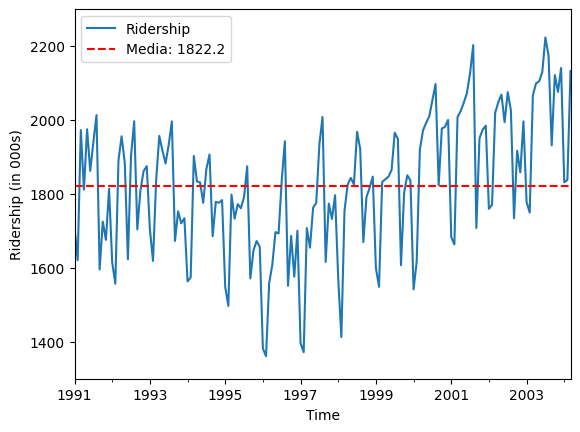

In [11]:
ax = ridership_ts.plot()
ax.set_xlabel('Time')
# ax.set_yscale('log')  # [se si vuole la y logaritmica]
ax.set_ylabel('Ridership (in 000s)')
_ = ax.set_ylim(1300, 2300)

# Aggiunta della linea orizzontale al valore medio
media = ridership_ts.mean()
ax.axhline(y=media, color='red', linestyle='--', label=f'Media: {media:.1f}')
ax.legend()

plt.show()


Il "livello" (la media generale della serie) sembra intorno a 1.800K al mese.<br>
C'è una leggera forma generale ad U ("U-shape), con una pronunciata stagionalità annuale, con picco dei viaggi in estate (luglio ed agosto) - NON ancora ben visibile da questo plot.<br>
Attenzione: la variabile in ascissa (gli indici temporali della serie) sono per definizione DISCRETI.<br>
La serie appare come CONTINUA solo perchè, per comodità, si sceglie in genere un 'line-chart', che appunto collega tutti i valori della serie con una linea. Cioè, in altre parole, questo grafico NON è come il pennino di un sismografo, che traccia una linea effettivamente continua.

In [12]:
ridership_ts.mean()     # la media aritemetica della serie

1822.1972075471697

In [13]:
ridership_ts.median()   # la mediana, cioè il valore della serie rispetto al quale il 50% degli altri valori è superiore
                        # e l'altro 50% è inferiore.

1831.049

In [14]:
ridership_ts.std()

181.63603371201944

## Nota sulle tecniche grafiche
Per esaminare più attentamente una serie storica (in modo grafico) sono molto utili questi strumenti:
* **zoom**: particolarmente utile con serie lunghe: può infatti rivelare pattern locali prima nascosti (vedi prossime celle);
* **cambio di scala**: ad es. il logaritmo per linearizzare / compattare un [andamento esponenziale](https://it.wikipedia.org/wiki/Funzione_esponenziale) [in *matplotlib* si usa *ax.set_yscale('log')*]; se il trend nella nuova scala sembra più o meno lineare significa allora che il trend nella vecchia scala è circa esponenziale ([esempio nella terza sezione](https://www.graphpad.com/guides/prism/latest/user-guide/when_to_use_a_logarithmic_axis.htm)); attenzione a [questa differenza](https://www.researchgate.net/figure/Comparison-of-exponential-and-logistic-growth_fig4_262891745), ad esempio nella diffusione pandemica;
* **sovrapposizione della linea di trend (ai dati "grezzi" della serie, *raw data*)**: è un'altra possibilità per meglio individuare l'andamento indicativo della serie, quello che meglio si adatta (*fitting*) ai dati ([vedi qui](Shapes.png) ed anche [questa voce di Wikipedia](https://it.wikipedia.org/wiki/Curve_fitting));
* **soppressione della stagionalità**, ad es. a) aggregando i dati, oppure b) creando serie/plot differenti per ogni stagionalità, oppure c) ancora usando un diagramma a media mobile (lo vedremo più avanti); la soppressione della stagionalità spesso aiuta ad identificare meglio gli eventuali trend / pattern della serie;
 
Sospendiamo un attimo l'analisi di *Amtrak* (che non ha la granularità sufficiente per fare zoom) ed utilizziamo un altro dataset più adatto per questa dimostrazione (**con granularità giornaliera**);<br>
Sono i passaggi GIORNALIERI sotto il tunnel svizzero di [Baregg](https://en.wikipedia.org/wiki/Baregg_Tunnel).<br>
Qui lo step o periodo è il **giorno**.

In [15]:
# l'esame del dataset
baregg_df = dmba.load_data('BareggTunnel.csv') # import con la utility di 'dmba', questa volta
print(baregg_df.shape,'\n')
print(type(baregg_df),'\n')
print(baregg_df,'\n')
print(baregg_df.info(),'\n') # --> è una stringa

(747, 2) 

<class 'pandas.core.frame.DataFrame'> 

             Day  Number of vehicles
0    01 Nov 2003              103536
1    02 Nov 2003               92051
2    03 Nov 2003              100795
3    04 Nov 2003              102352
4    05 Nov 2003              106569
..           ...                 ...
742  12 Nov 2005              104646
743  13 Nov 2005               94424
744  14 Nov 2005              112165
745  15 Nov 2005              114296
746  16 Nov 2005              114690

[747 rows x 2 columns] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Day                 747 non-null    object
 1   Number of vehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None 



In [16]:
# conversione della data da oggetto stringa ('object data type') ad oggetto 'datetime':
baregg_df['Date'] = pd.to_datetime(baregg_df.Day, format='%d %b %Y')

# creazione della serie PIENA dei VALORI(senza visualizzazione):
vehicles_ts = pd.Series(baregg_df['Number of vehicles'].values, index=baregg_df.Date, name='Vehicles')

In [17]:
baregg_df.dtypes

Day                           object
Number of vehicles             int64
Date                  datetime64[ns]
dtype: object

In [18]:
vehicles_ts

Date
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Name: Vehicles, Length: 747, dtype: int64

In [19]:
vehicles_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 747 entries, 2003-11-01 to 2005-11-16
Series name: Vehicles
Non-Null Count  Dtype
--------------  -----
747 non-null    int64
dtypes: int64(1)
memory usage: 11.7 KB


Come detto, un tipico secondo passo, dopo il line-chart generale, è lo ZOOM.<br>
Creiamo una serie PIU' RISTRETTA di questo dataset (zooming-in), sempre con il package *matplotlib*: una sotto-serie di 4 mesi:

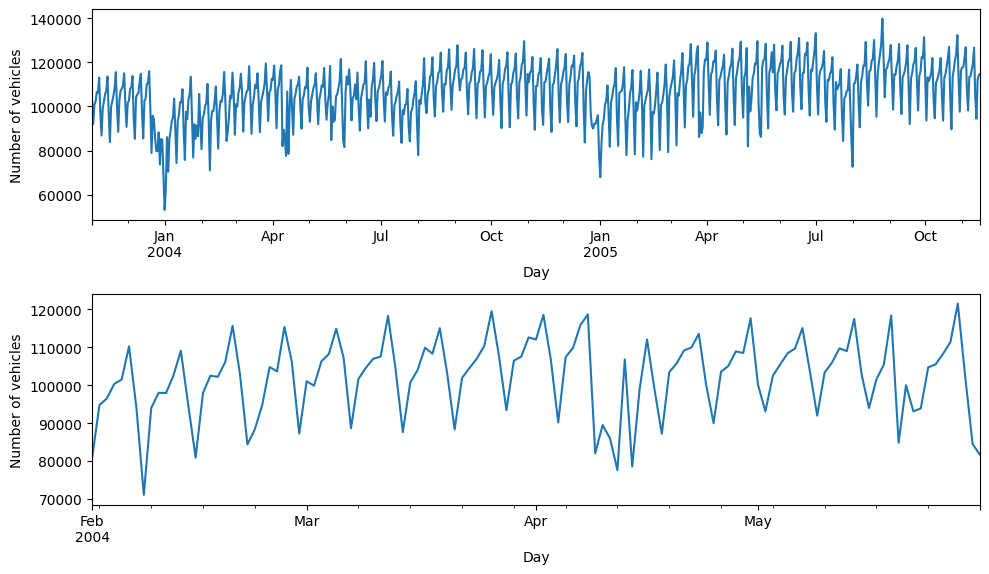

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6)) # 2 sottoplot

     # 'fig, ax' è molto frequente in matplotlib.
     # da stackoverflow (post 34162443): "plt.subplots() is a function that returns a tuple containing a 
     # figure and axes object(s). Thus when using:
     #     'fig, ax = plt.subplots()'
     # you unpack this tuple into the variables 'fig' and 'ax'. Having 'fig' is useful if you want to change
     # figure-level attributes or save the figure as an image file later, e.g. with:
     #     'fig.savefig('yourfilename.png'). 
     # You maybe don't have to use the returned figure object but many people do use it later so it's common
     # to see it. 
     # Also, all axes objects (the objects that have plotting methods), have a parent figure object anyway, 
     # thus: 
     #     'fig, ax = plt.subplots()' 
     # is more concise than: 
     #     'fig = plt.figure()'
     #     'ax = fig.add_subplot(111)
     # If you want 4 graphs, you could have ax11, ax12, ax21, ax22 by using:
     #     'fig.add_subplot(221)'
     # or 222, 223, 224 respectively.


vehicles_ts.plot(ax=axes[0])
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Number of vehicles')
vehicles_ts['2004-02-01':'2004-05-31'].plot(ax=axes[1]) # <-- la serie ristretta di 4 mesi
                                                        #     importante tecnica di subsetting di serie temporali
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of vehicles')
plt.suptitle('')    # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show() # --> si nota nello zoom (secondo plot) un chiaro pattern sul giorno della settimana, non visibile sul chart
           #     generale (dei 2 anni).

Risulta qui evidente che nei giorni del fine settimana c'è una forte diminuzione dei passaggi.

## Fit lineare e quadratico
Torniamo al dataset Amtrak.

Dopo avere analizzato la serie vogliamo **adattare ad essa (*fitting*) un modello di regressione**: ci serve per <u>cogliere meglio l'andamento</u> della serie (e poi, nel prossimo notebook, anche per prevedere il futuro).<br>
Quale tipo di regressione scegliere? Lineare, quadratica, esponenziale, logaritmica, ecc?<br>
Una prima indicazione la fornisce il plot a linea (*line-chart*) fatto prima.<br>
Poichè il plot generale della serie intera mostra **un leggero andamento ad U**, è probabilmente opportuno utilizzare una regressione **polinomiale (quadratica)** per fittare il trend. Si noti che, da un punto di vista matematico, l'equazione di regressione, in questo caso, è ancora lineare perchè le variabili del problema di ottimizzazione non sono i predittori (*trend*, *trend^2*) ma i coefficienti beta-i.<br>
In altri casi, su altre serie temporali, l'esame visivo potrebbe suggerire di usare una regressione di altro tipo.<br>
Cioè, in prima approssimazione, la scelta del modello (lineare, quadratico, polinomiale, esponenziale, logaritmico, sinusoidale, ecc) è fatta in modo **soggettivo**, cioè in base al **mero esame visivo della serie temporale**. Ovviamente, esistono anche criteri oggettivi (**metriche**) per scegliere il modello in modo <u>più affidabile</u>, che vedremo più avanti.<br>
In assenza di un chiaro pattern nel *line-chart* il modo standard di procedere è **assumere** che il trend della serie sia (abbastanza) **LINEARE** (nel periodo osservato e nei primi mesi successivi oggetto di forecasting) ed il rumore sia [**GAUSSIANO**](https://it.wikipedia.org/wiki/Distribuzione_normale) [e quindi, la casualità abbastanza simmetrica]. 

Facciamo il fit di **due modelli** con la **regressione OLS (OLS=Ordinary Least Squares)**:
- con un modello LINEARE su una serie limitata di 3 anni (che presenta in questa serie dati un andamento lineare)
- con un modello QUADRATICO sulla serie dati intera.
  
In entrambi i modelli la regressione OLS è lineare rispetto ai coefficienti beta-i.

Per prima cosa, creiamo una **serie più ristretta (zooming-in)**, con tre anni da Jan 1997 a Dec 1999, tramite **SLICING**: 

In [21]:
ridership_ts_3yrs = ridership_ts['1997':'1999']
display(ridership_ts_3yrs.head())
display(ridership_ts_3yrs.tail())
print("\n",type(ridership_ts_3yrs))  # è una 'Series'

Date
1997-01-01    1396.588
1997-02-01    1371.690
1997-03-01    1707.522
1997-04-01    1654.604
1997-05-01    1762.903
Freq: MS, Name: Ridership, dtype: float64

Date
1999-08-01    1949.002
1999-09-01    1607.373
1999-10-01    1803.664
1999-11-01    1850.309
1999-12-01    1836.435
Freq: MS, Name: Ridership, dtype: float64


 <class 'pandas.core.series.Series'>


Per fittare il modello di regressione ai nostri dati usiamo il package `tsatools` della libreria `statsmodels` che è un'alternativa alla libreria `scikit-learn` (che ha meno funzioni di TSA).

Il package `tsatools` di `statsmodels` richiede che il data-frame (o la serie dati!) abbia **alcune colonne in più**: 
- un termine costante ed un termine di trend per una regressione lineare
- anche un termine quadratico di trend per una regressione quadratica.<br>

La funzione `add_trend` aggiunge un trend e/o una costante ai dati. 

In [22]:
ridership_df_3yrs = tsatools.add_trend(ridership_ts_3yrs, trend='ct')  # dall'help on-line (premere shift+tab dopo aver posizionato
                                                                        # il cursore ALL'INTERNO delle parentesi della funzione):
                                                                        # --> 'ctt' adds constant and linear and quadratic trend.
                                                                        # NB: La costante (intercetta) è in genere consigliabile.

print('\n',ridership_df_3yrs)                                 # --> dall'help on-line: "The original data with the additional 
                                                              # trend columns. If x is a pandas 'Series' or 'DataFrame', then 
                                                              # the trend column names are ‘const’, ‘trend’ and ‘trend_squared’.
                                                              # Returns columns as ['ctt','ct','c'] whenever applicable. There 
                                                              # is currently no checking for an existing trend.
                
                                                              # E', per certi versi, il metodo di CREAZIONE dell'ISTANZA con la
                                                              # sua struttura.
                                                              # La successiva funzione 'sm.ols.fit' richiede infatti in input
                                                              # un dataframe [NON è lo standard scikit-learn!]


             Ridership  const  trend
Date                               
1997-01-01   1396.588    1.0    1.0
1997-02-01   1371.690    1.0    2.0
1997-03-01   1707.522    1.0    3.0
1997-04-01   1654.604    1.0    4.0
1997-05-01   1762.903    1.0    5.0
1997-06-01   1775.800    1.0    6.0
1997-07-01   1934.219    1.0    7.0
1997-08-01   2008.055    1.0    8.0
1997-09-01   1615.924    1.0    9.0
1997-10-01   1773.910    1.0   10.0
1997-11-01   1732.368    1.0   11.0
1997-12-01   1796.626    1.0   12.0
1998-01-01   1570.330    1.0   13.0
1998-02-01   1412.691    1.0   14.0
1998-03-01   1754.641    1.0   15.0
1998-04-01   1824.932    1.0   16.0
1998-05-01   1843.289    1.0   17.0
1998-06-01   1825.964    1.0   18.0
1998-07-01   1968.172    1.0   19.0
1998-08-01   1921.645    1.0   20.0
1998-09-01   1669.597    1.0   21.0
1998-10-01   1791.474    1.0   22.0
1998-11-01   1816.714    1.0   23.0
1998-12-01   1846.754    1.0   24.0
1999-01-01   1599.427    1.0   25.0
1999-02-01   1548.804    1

Fittiamo ora il PRIMO modello di regressione lineare OLS sulla sotto-serie. NON si usa lo stimatore generico 'LinearRegression'!!

In [24]:
import numpy as np

# la funzione 'add_trend' "Creates a Model from a formula and dataframe".
ridership_lm_3yrs = sm.ols(formula='Ridership ~ trend', data=ridership_df_3yrs).fit() # 
                                                      # NB. Un modello di regressione è 'lineare' rispetto ai coefficienti,
                                                      # non rispetto alle variabili (qui, 'trend' alle varie potenze).

# alternativa, senza la 'add_trend': DMBA, p. 429-430]:
# ridership_lm = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=ridership_df_3yrs).fit() # 

        
type(ridership_lm_3yrs)

statsmodels.regression.linear_model.RegressionResultsWrapper

Ora arricchiamo la serie con le colonne in più per il SECONDO modello:

In [25]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ctt')            # dall'help on-line (premere shift+tab dopo aver posizionato
                                                                        # il cursore ALL'INTERNO delle parentesi della funzione):
                                                                        # --> 'ctt' adds constant and linear and quadratic trend.
                                                                        # NB: La costante (intercetta) è in genere consigliabile.

print('\n',ridership_df)  


             Ridership  const  trend  trend_squared
Date                                              
1991-01-01   1708.917    1.0    1.0            1.0
1991-02-01   1620.586    1.0    2.0            4.0
1991-03-01   1972.715    1.0    3.0            9.0
1991-04-01   1811.665    1.0    4.0           16.0
1991-05-01   1974.964    1.0    5.0           25.0
...               ...    ...    ...            ...
2003-11-01   2076.054    1.0  155.0        24025.0
2003-12-01   2140.677    1.0  156.0        24336.0
2004-01-01   1831.508    1.0  157.0        24649.0
2004-02-01   1838.006    1.0  158.0        24964.0
2004-03-01   2132.446    1.0  159.0        25281.0

[159 rows x 4 columns]


Fittiamo ora il SECONDO modello di regressione lineare OLS alla serie INTERA. Anche qui NON si usa lo stimatore generico 'LinearRegression'!!

In [26]:
import numpy as np

# la funzione 'add_trend' "Creates a Model from a formula and dataframe".
ridership_lm = sm.ols(formula='Ridership ~ trend + trend_squared', data=ridership_df).fit() # 
                                                      # NB. Un modello di regressione è 'lineare' rispetto ai coefficienti,
                                                      # non rispetto alle variabili (qui, 'trend' alle varie potenze).

# alternativa, senza la 'add_trend': DMBA, p. 429-430]:
# ridership_lm = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=ridership_df_3yrs).fit() # 

        
type(ridership_lm)

statsmodels.regression.linear_model.RegressionResultsWrapper

Ora che abbiamo costruito i due modelli di regressione possiamo fare i due plot a confronto (con i due modelli sovra-imposti):

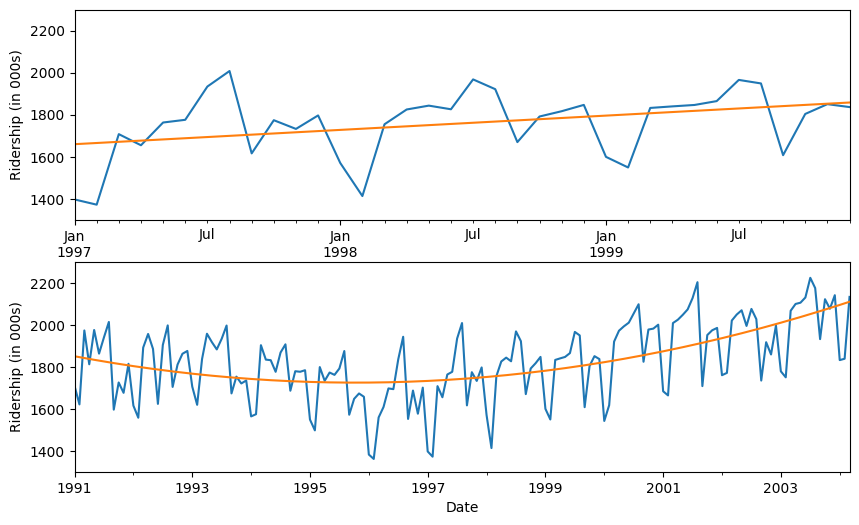

In [30]:
# impostazione del plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

# l'asse X (differente)
ridership_ts_3yrs.plot(ax=axes[0]) # la serie ridotta (i 3 anni)
ridership_ts.plot(ax=axes[1])      # la serie piena

# gli altri elementi (comuni ai due subplot) 
for ax in axes:
    ax.set_xlabel('Date')                            # la stessa label di ascissa per i due plot
    ax.set_ylabel('Ridership (in 000s)')             # la stessa label di ordinata per i due plot
    ax.set_ylim(1300, 2300)                          # gli stessi limiti di valori in ordinata per i due plot

# i due fit
ridership_lm_3yrs.predict(ridership_df_3yrs).plot(ax=axes[0])  # le previsioni con il PRIMO modello.
ridership_lm.predict(ridership_df).plot(ax=axes[1])            # le previsioni con il SECONDO modello.
                                                               # Si noti il tipico pipeling dei metodi (in cascata).

plt.show()                                           # --> I due grafici aiutano a rendere le componenti più visibili.

                                                     # --> La serie ha una FORTE stagionalità estiva.

Più avanti vedremo come estrarre dal modello fittato i **coefficienti** della curva / retta / iperpiano).

L'ultima componente da esaminare è l'[auto-correlazione](Autocorrelation.png), che riprenderemo meglio nella seconda giornata del corso.<br>
Da notare, comunque, che questa auto-correlazione, come si vede bene nel grafico, non è una stagionalità perchè:
* il t0 di inizio del ciclo (di decadimento) è irregolare (non prevedibile);
* il pattern ciclico (il decadimento) ha forme differenti tra loro.

## Riassunto sulle componenti
E' davvero importante imparare a riconoscere i **pattern di time-series** più diffusi, perchè i metodi di Machine Learning che si applicano sono differenti.<br>
Attenzione: si tratta comunque sempre di valutazioni in parte **soggettive**.<br>

[I trend e le stagionalità GLOBALI più comuni (Galit Shmueli - Axelrod Schnall Publishers - 2016)](Common_patterns_shmueli.png)<br>

[Video riassuntivo sui pattern (da *coursera*)](https://www.youtube.com/watch?v=_z-a6WoNC2s&t=131s)<br>

[Le slide del video precedente - parte 1](Common_patterns_in_TS.png)<br>
[Le slide del video precedente - parte 2](Common_patterns_in_TS_2.png)<br>
[Le slide del video precedente - parte 3](Common_patterns_in_TS_3.png)<br>
[Le slide del video precedente - parte 4](Common_patterns_in_TS_4.png)<br>

# Metodi (cioè gli algoritmi) di forecasting (*ML predittivo*)

Ora vogliamo fare **PREVISIONE** sul futuro (forecasting). Potremmo usare il modello di regressione quadratica prima fittato. Vogliamo qui usare due algoritmi più semplici: **naive forecast** e il **seasonal naive forecast**. [Vedi altro notebook per la previsione con la regressione]

**Note sui metodi di ML**:
* <u>parametrici</u> (diretti): fanno delle **assunzioni sulle componenti** della serie, ad esempio che il trend in un certo periodo è lineare oppure quadratico od esponenziale; oppure che il rumore è [gaussiano](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,take%20on%20are%20Gaussian%2Ddistributed.);
* i metodi parametrici funzionano molto bene se le assunzioni sono (abbastanza) vere;
* altrimenti si usano metodi <u>non-parametrici</u>, anche detti *distribution-free* oppure *data-driven*, che fanno meno assunzioni sulla struttura delle componenti della serie;
* i metodi non-parametrici sono utili appunto quando le assunzioni probabilmente non sono soddisfatte oppure quando <u>il comportamento della serie cambia nel tempo</u>; sono inoltre semplici e computazionalmente veloci, tuttavia richiedono molti dati;
* un **criterio importante** per decidere quale tipo di metodo di forecasting usare è la presenza di <u>pattern globali</u> (cioè che sono abbastanza costanti su tutta la serie) oppure [locali](https://www.researchgate.net/figure/A-shapelet-red-dotted-line-capturing-a-local-pattern-of-a-time-series-blue-solid_fig2_331532370), che cioè avvengono solo in un breve periodo della serie; 
* se i pattern della serie sono globali, i metodi parametrici sono preferibili perchè usano tutti i dati disponibili;
* se i pattern sono locali, al contrario, il metodo parametrico dovrebbe essere applicato ad ogni differente sottosezione della serie, che non è pratico e spesso non noto;
* attenzione: non confondere i pattern locali con [le sotto-popolazioni](Patterns.png), che cioè descrivono fenomeni differenti;
* i pattern locali **imparano** il pattern dai dati, e la loro <u>memoria</u> (l'ampiezza del periodo al quale si applicano) può essere lunga (per pattern che cambiano lentamente nel tempo) oppure breve (per pattern dinamici nel tempo).


**I plot visti sopra servono non solo ad identificare meglio le 6 componenti, ma anche a decidere se la natura di trend/pattern/stagionalità è <u>locale o globale</u>**.

Le serie temporali [*white noise*](https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20is%20white%20noise%20if%20the%20variables%20are,with%20a%20mean%20of%20zero.&text=If%20the%20variables%20in%20the,is%20called%20Gaussian%20white%20noise.) **non sono prevedibili** perchè puramente casuali. Vedi [esempio](White_noise.png), che contiene anche un link ad un **ottimo e-book** sul forecasting con le time series (TSF) in Python.

# Partizionamento dei dati e previsione (*forecast*)
Come per tutti i metodi di ML *predittivo*, occorre per prima cosa suddividere il dataset in **training** set, sul quale si allena il modello, e **test set (o validation set**), sul quale lo si valuta. Le previsioni saranno poi fatte per i **valori futuri**. Cioè il passato serve a prevedere il futuro ed è diviso in training e test.<br>

Lavoriamo sulla serie dati completa (159 mesi).

[In generale](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets); ci sono delle peculiarità delle serie temporali che vedremo più avanti (la successione cronologica).<br>

[La regola del pollice di Hastie & Tibshirani](Percentuali_partizionamento.png)

In [32]:
# split dati in periodo di training e periodo di validazione (=test!) del modello (SUCCESSIVI per le serie temporali):

nValid = 36                           # periodo di validazione (test): gli ultimi 36 mesi della serie (22%) 
                                      # (da Aprile 2001 a Marzo 2004); 
                                      # non c'è casualità (e quindi non serve un seme).

nTrain = len(ridership_ts) - nValid   # periodo di training: i 123 mesi precedenti (da Gennaio 1991 a marzo 2001).
                                      # [la serie totale è di 159 mesi --> 159-36 = 123.]
    
# partizionamento dei dati [vedi tecniche di subsetting di python e pandas]:
train_ts = ridership_ts[:nTrain]    # subsetting: tutti gli elementi della serie sino a 'nTrain'-1; 
valid_ts = ridership_ts[nTrain:]    #    "          "                            da 'nTrain' in poi;
                                    # --> regole di subsetting delle 'Series' coerenti con quelle dei 'dataframe'.
print(train_ts.shape)
print(valid_ts.shape)

# --> ESAME variabili (nome, tipo, shape, valore, ecc) con il Variable Inspector

(123,)
(36,)


In [33]:
print(valid_ts)

Date
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
2002-01-01    1759.629
2002-02-01    1770.595
2002-03-01    2019.912
2002-04-01    2048.398
2002-05-01    2068.763
2002-06-01    1994.267
2002-07-01    2075.258
2002-08-01    2026.560
2002-09-01    1734.155
2002-10-01    1916.771
2002-11-01    1858.345
2002-12-01    1996.352
2003-01-01    1778.033
2003-02-01    1749.489
2003-03-01    2066.466
2003-04-01    2098.899
2003-05-01    2104.911
2003-06-01    2129.671
2003-07-01    2223.349
2003-08-01    2174.360
2003-09-01    1931.406
2003-10-01    2121.470
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, dtype: float64


In [34]:
# PROVE di subsetting di 'train_ts' (utili per dopo):
print(train_ts,'\n')            # tutta la serie
print(train_ts.iloc[0])         # il primo elemento
print(train_ts.iloc[-1])        # l'ultimo elemento
print(train_ts.iloc[-2:])       # gli ultimi due elementi

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, Length: 123, dtype: float64 

1708.917
2007.928
Date
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, dtype: float64


Utilizziamo ora due metodi di forecasting (del prossimo valore futuro) semplici (per imparare) ma spesso efficaci (tant'è che costituiscono un "benchmark" di riferimento non facile da battere):
* **naive forecast**: l'ultimo valore, cioè il valore dell'elemento k+1 della serie (*forecasted*) è semplicemente il valore dell'ultimo elemento k (*actual*);
* **seasonal naive forecast** (stagionale): utile quando la serie presenta delle <u>stagionalità</u>; è l'ultimo valore *simile* nella stagione. Ad esempio: per il forecast di Aprile 2001, *seasonal naive forecast* usa il numero viaggiatori dell'ultimo aprile del set di training (nel 2000). Lo stesso per il forecast di aprile 2002 (il valore di aprile 2000, nuovamente, perchè DENTRO il dataset di training)


In [40]:
# Previsioni con i due metodi:

naive_pred = pd.Series(train_ts.iloc[-1], index=valid_ts.index) # --> con 'naive forecast' la previsione è 
                                                                #     semplicemente l'ultimo valore

last_season = train_ts.iloc[-12:]                               # gli ultimi 12 valori (la stagionalità da considerare)
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

Cosa fa questa istruzione?
```python
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)
```

Estrae gli ultimi 12 valori da `train_ts`, che rappresentano l’ultima stagione completa (la stagionalità è mensile).<br>
Ripete quei 12 valori per 5 volte (ottenendo una serie di 60 valori).<br>
Prende solo i primi `len(valid_ts)` valori da quella serie (es. i primi 36, se la validazione è su 3 anni).<br>
Crea la serie di previsione con questi valori, mantenendo le stesse date di `valid_ts`.<br>

Esempio concreto: se `train_ts` finisce a dicembre e contiene dati mensili, `last_season` sarà da gennaio a dicembre. La previsione sarà:<br>
Gennaio → uguale a gennaio scorso<br>
Febbraio → uguale a febbraio scorso<br>
… e così via per 3 anni (36 mesi)


In [ ]:
print(naive_pred)              # --> 36 valori tutti uguali
print('\n',seasonal_pred)      # --> 36 valori uguali a quello del rispettivo mese dell'ultimo anno ('last_season')

In [38]:
ridership_ts['2000':'2004'] # i valori effettivi (per confronto)

Date
2000-01-01    1541.660
2000-02-01    1616.928
2000-03-01    1919.538
2000-04-01    1971.493
2000-05-01    1992.301
2000-06-01    2009.763
2000-07-01    2053.996
2000-08-01    2097.471
2000-09-01    1823.706
2000-10-01    1976.997
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
2002-01-01    1759.629
2002-02-01    1770.595
2002-03-01    2019.912
2002-04-01    2048.398
2002-05-01    2068.763
2002-06-01    1994.267
2002-07-01    2075.258
2002-08-01    2026.560
2002-09-01    1734.155
2002-10-01    1916.771
2002-11-01    1858.345
2002-12-01    1996.352
2003-01-01    1778.033
2003-02-01    1749.489
2003-03-01    2066.466
2003-04-01    2098.899
2003-05-01    2104.911
2003-06-01    2129.671
2003-07-01    2223.349
2003-0

[Il funzionamento del Seasonal Naive Forecast su questi dataset](SNF_esempio.png)<br>

Nel Machine Learning, e quindi anche nelle serie temporali, c'è in genere un **benchmark base, anche detto di riferimento**, che sono i risultati forniti dall'algoritmo più semplice. Il benchmark base è quello "da battere".<br><br>
Il **benchmark base** nel TSF è, come spesso nel ML, <u>la mera MEDIA di tutti i valori della serie</u>.<br><br>
NF e SNF battono in genere il benchmark base, cioè forniscono previsioni migliori perchè considerano solo il <u>passato recente</u> (anche se solo quello ultimissimo), e costituiscono quindi, di fatto, il **vero benchmark di riferimento** che gli altri metodi di TSF devono cercare di battere (previsioni ancora migliori).<br><br>
**Previsione buona/ottima**: il <u>residuo</u>, cioè la differenza tra il valore t+k della serie <u>previsto e quello effettivo</u>, è piccolo. Il residuo è anche detto: *errore di forecast*.<br>
Storicamente, il termine *residuo* è nato per indicare ciò che RESTA dopo l'applicazione (il fit) del modello alla serie, cioè ciò che NON è modellato dal modello stesso, cioò che non è **SPIEGATO** da esso.<br>
Il residuo è riferito alla SINGOLA previsione; i vari residui possono poi essere aggregati in una metrica di valutazione complessiva della bontà predittiva del modello su TUTTA la serie, o comunque su tutto l'intervallo di osservazione scelto (ad esempio di test).

In [ ]:
# plot dei forecast e degli actual nel dataset di training ed in quello di validazione:

ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
# ax.set_xlim('1990', '2006-06-01')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


# Determinare le coordinate per disegnare frecce e linee:
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, max(valid_ts.index) + 20 * one_month)
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])
ax.set_xlim(min(train_ts.index) - 6 * one_month, max(valid_ts.index) + 24 * one_month)

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validazione')
ax.text('2004-7', 2500, 'Futuro')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
plt.show()

                             # --> per il dataset di validazione il grafico mostra:
                             #     * forecast naive, UGUALE per tutti i mesi: la linea verde orizzontale;
                             #     * forecast naive stagionale, VARIABILE: la curva arancione (si noti la ciclicità 
                             #       triennale);
                             #     * i valori effettivi (actual): la curva punteggiata.

# Valutazione della capacità predittiva
Infine, come in tutte le tecniche di ML previsionali (supervisionate), misuriamo in modo oggettivo **l'accuratezza** dei due metodi naive ora visti, con le metriche delle previsioni numeriche: ME, [Rooted MSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), MAE, ecc. NB. [questa](RMSE_TS.png) è la formula dell'RMSE della pagina Wikipedia da usare per le serie temporali]<br>
L'accuratezza si misura sempre e solo sul dataset di validazione/test, perchè quello di training è già stato usato per allenare il modello (*il fitting*). L'accuratezza del futuro non è misurabile perchè NON conosciamo i valori effettivi (futuri); invece, li conosciamo per il dataset di validazione.

Per una definizione in Python delle suddette metriche (anche dette *loss function*) vedi il codice dell'utility *regressionSummary* a questo [indirizzo github](https://github.com/gedeck/dmba) [e poi --> src --> dmba --> metric.py].

In [ ]:
regressionSummary(valid_ts, naive_pred)              # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con forecast naive.

La metrica di errore aggregato più affidabile è RMSE.<br>
RMSE = 142.75 vuol dire che, in media, l'errore di previsione del metodo naive forecast è di +/- 142.75.

In [ ]:
np.power(142.7551,2) # --> MSE (senza radice quadrata): non è nella scala della risposta (ridership)
                     #     20379 migliaia significa 20 milioni e rotti 

In [ ]:
regressionSummary(valid_ts, seasonal_pred)           # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con seasonal forecast naive.

**NOTE** sulle metriche di errore:
* poichè il dataset 'Amtrak' ha delle stagionalità mensili, il metodo stagionale (Seasonal Naive Forecast) vince nettamente (sul Naive Forecast) con tutte le metriche; 
* le metriche di "norma-0" possono fornire valori negativi;
* in generale, le metriche di errore di norma-2 (L2 norm, es MSE oppure RMSE), cioè con i quadrati, sono preferibili alle norme-1 (L1-norm, es MAE), cioè i valori assoluti, perchè sempre differenziabili (su tutto il dominio della variabile indipendente).
                            


Ancorchè in questa serie temporale Amtrak (e con questi subset di training e di validazione: 123 e 36 mesi) l'errore di training sia maggiore di quello di test/validazione (cosa poco usuale, peraltro), **si deve comunque usare sempre e solo  l'errore sul validation test perchè è più significativo**.

In [ ]:
# Ecco come si calcola l'errore di training:

print('\n','naive model in training set')
regressionSummary(train_ts[1:], train_ts[:-1]) # 

print('\n','seasonal model in training set')
regressionSummary(train_ts[12:], train_ts[:-12])                            

La funzione `regressionSummary` prima utilizzata non riporta la metrica MSE, che alcuni preferiscono utilizzare. Vediamo allora come calcolare MSE in python (per il caso Amtrak) del metodo **SNF**:

In [ ]:
# MSE per il SNF (calcolato con scikit-learn)
from sklearn.metrics import mean_squared_error   # RMSE non è direttamente disponibile
MSE = mean_squared_error(y_true=valid_ts,y_pred=seasonal_pred)  
print("Mean Square Error sk-learn: ",round(MSE,2))

# MSE sempre per il SNF (calcolato con 'numpy'):
MSE_2 = np.square(np.subtract(valid_ts,seasonal_pred)).mean()   # MSE calcolato con 'numpy'
print("Mean Square Error numpy: ",round(MSE_2,2))

# i due RMSE:
RMSE = math.sqrt(MSE)
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error (scikit-learn): ",round(RMSE,2))
print("Root Mean Square Error (numpy): ",round(RMSE_2,2))

**Bottom-line**: il benchmark di riferimento per la serie Amtrak (sul dataset di test) è quindi **95.62** (del Seasonal NF), che rappresenta il valore da battere per altri eventuali algoritmi.

In [ ]:
# Come utilizzare questi numeri? Per due scopi:
# - confrontare metodi TSF differenti e valutarli comparativamente sul validation set --> il metodo con metrica di errore 
#   (ad es. RMSE) più bassa sarà quello che utilizziamo per le VERE previsioni (valori FUTURI della serie non ancora noti);
# - interpretare i risultati (le previsioni)
seasonal_pred # --> alla luce del RMSE (= 95.62) le previsioni fornite dal metodo TSF (qui SNF), elencate per 
              #     comodità qui sotto, sono da intendersi MEDIAMENTE errate per +/- 95.62.
              # --> cioè, in altre parole, 1971.493 è la previsione PUNTUALE per APR-04;
              #     [(1971.43 - 95.62),(1971.43 + 95.62)] è la previsione INTERVALLARE con +/- 1 RMSE
              # --> [(1971.43 - 2*95.62),(1971.43 + 2*95.62)] è la previsione INTERVALLARE con +/- 2 RMSE (conservativa)
# Uno dei vantaggi di RMSE è proprio che, essendo definito nella stessa scala originaria (qui  le migliaia di passeggeri 
# mensili), può essere utilizzato per costruire gli INTERVALLI di CONFIDENZA.  

Le stime ora viste sono **puntuali**. In realtà, gli algoritmi di ML predittivo forniscono stime **intervallari**: la stima puntuale è semplicemente il centro dell'intervallo. Le stime intervallari hanno un livello di confidenza, che in genere è 90%, 95%, 99%. La scelta del livello dipende dal grado di rischio che tolleriamo. Ad esempio, un livello del 95% significa che accettiamo il 5% di errore, cioè che in un caso su 20 il valore effettivo (che conosceremo solo nel futuro) sarà fuori dalla stima intervallare.

In [ ]:
# Usiamo qui RMSE come stima della deviazione standard:
print([(1971.43 - 95.62),(1971.43 + 95.62)])      # l'intervallo di confidenza 1sigma della stima di aprile 2001,cioè al 68%
print([(1971.43 - 2*95.62),(1971.43 + 2*95.62)])  # l'intervallo di confidenza 2sigma della stima di aprile 2001,cioè al 95%
print([(1971.43 - 3*95.62),(1971.43 + 3*95.62)])  # l'intervallo di confidenza 3sigma della stima di aprile 2001,cioè al 99%

Forecaster delle serie temporali in genere migliori del naive e seasonal naive sono (ad esempio):
* regressione
* smoothing
* exponential smoothing
* ecc

Nei prossimi notebook vedremo se questi metodi (più sofisticati) riescono a battere il benchmark 95.62.

**[NOTA matematica sulle *loss function* - facoltativo]**<br>
[Slide 1](Slide_loss_function_1.png)<br>
[Slide 2](Slide_loss_function_2.png)<br>
[Slide 3](Slide_loss_function_3.png)

# Forecast sul futuro
Per fare FORECAST del FUTURO (quello che ci interessa), occorre RICOMBINARE i due dataset (cioè considerare nuovamente **l'intero** dataset originale) e riadattare (*ri-fittare*) il metodo **scelto** (qui il naive stagionale) sulla serie completa.<br>
[Ancorchè ciò sia comune anche con i dati *cross-sectional*, con le *time series* è **indispensabile**.] 

## C con le TS? 
Le serie temporali (o altri dati intrinsecamente ordinati) possono essere problematici per la convalida incrociata (CV).
Un approccio tipico (ma **errato** per le TS) con la CV per TS, qui k=6 (numero-iterazioni) --> 6 fold, è il seguente:
* iter 1: training [1 2 3 4 5], test [6]
* iter 2: training [1 2 3 4 6], test [5]
* iter 3: training [1 2 3 5 6], test [4]
* iter 4: training [1 2 4 5 6], test [3]
* iter 5: training [1 3 4 5 6], test [2]
* iter 6: training [2 3 4 5 6], test [1]
dove il training set è ordinato temporalmente, ma non il test set rispetto al training set.

Se qualche prodotto emerge nell'anno 3 e rimane per 4-6 anni, i dataset NON sono più indipendenti.

Un approccio più frequente (per la CV nelle TS) è il **concatenamento diretto**, in cui la procedura è simile a questa:
* iter 1: training [1],         test [2]
* iter 2: training [1 2],       test [3]
* iter 3: training [1 2 3],     test [4]
* iter 4: training [1 2 3 4],   test [5]
* iter 5: training [1 2 3 4 5], test [6]<br>
In questo caso il numero-iter = numero-fold -1

I dati di training sono sempre **consecutivi (senza buchi)**, i dati di test sempre successivi a quelli di training.
E’ una suddivisione più corretta, anche perché prevede sempre dati futuri in base a dati passati.<br>
Per eventualmente ovviare alla differente affidabilità dei RMSE (perchè ottenuti con metodi di TSF allenati su training set di dimensioni anche molto differenti, e quindi diversamente affidabili), è possibile **pesare** diferentemente i k RMSE, anzichè farne la mera media (aritmetica e quindi non-pesata). Ad es. attribuendo, con 4 fold e 3 iterazioni, pesi: iter-1 = 0.2; iter-2 = 0.3; iter-3=0.5.

**CV per le Time Series**<br>
![](CV_with_TS.png)

# Novità in Python per la gestione delle serie temporali:


[Post](https://www.linkedin.com/posts/davide-nardini_timeseries-timeseriesanalysis-tsfresh-activity-7138435215399514112-llpn?utm_source=share&utm_medium=member_desktop) di Davide Nardini (7 dicembre 2023) su [tsfresh](https://tsfresh.readthedocs.io/en/latest/).

[Post](https://www.linkedin.com/posts/davide-nardini_aeon-timeseries-timeseriesanalysis-activity-7140972182129500160-OMbZ?utm_source=share&utm_medium=member_desktop) di Davide Nardini (14 dicembre 2023) su *aeon*.

[Post](https://www.linkedin.com/posts/avi-chawla_heres-how-trigonometry-can-help-you-build-activity-7184837598136184832-WVNC?utm_source=share&utm_medium=member_desktop) di Avi Chawla (aprile 2024) sulle *cyclical features*. Vedi anche [qui](https://blog.dailydoseofds.com/p/a-critical-feature-engineering-direction).
![](cyclical_features.png)